# Выбор локации для скважины

## Описание и цели проекта

Нефтяной добывающей компании необходимо решить в каком регионе бурить скважину.

Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Для поиска и принятия решения предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Затем проанализировать возможную прибыль и риски убытков.

`План исследования:`
- Загружаем и подготавливаем данные.
- Обучаем и проверяем модель для каждого региона.
- Находим средний запас предсказанного сырья и RMSE модели.
- Рассчитываем достаточный объём сырья для безубыточной разработки новой скважины.
- Сравниваем полученный объём сырья со средним запасом в каждом регионе. 
- Пишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
- Выбераем скважины с максимальными значениями предсказаний. 
- Рассчитываем прибыль для полученного объёма сырья и считаем риски и прибыль для каждого региона. Для того, чтобы найти распределение прибыли применим технику Bootstrap с 1000 выборок.
- Находим среднюю прибыль, 95%-й доверительный интервал и риск убытков
- На основании полученных результатов предлагаем регион для разработки скважин.

`Описание данных`
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

`Условия задачи:`
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирать регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [6]:
#pip install ydata-profiling

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from ydata_profiling import ProfileReport

In [3]:
try:
    df_1 = pd.read_csv('/datasets/geo_data_0.csv')
    df_2 = pd.read_csv('/datasets/geo_data_1.csv')
    df_3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    df_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)


In [ ]:
#ProfileReport(df_1)

In [5]:
# Для более быстрого получения информации о данных создадим словарь
group_df = {'region_1':df_1, 'region_2':df_2, 'region_3':df_3}

In [6]:
# Посмотрим на исходные данные
for name,i in group_df.items():
    print(colored(name, attrs=['bold']))
    print('')
    display(i.head(), i.info(), i.describe())
    print('--------------------------------')

region_1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


None

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


--------------------------------
region_2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


None

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


--------------------------------
region_3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


None

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


--------------------------------


In [7]:
# Посмотрим наличие дубликатов по каждому датафрейму
for name,i in group_df.items():
    print(name,': Количество дубликатов', i['id'].duplicated().sum())
    display(i[i.id.duplicated(keep=False)].sort_values(by='id'))
    print('---------------------------------------')

region_1 : Количество дубликатов 10


,id,f0,f1,f2,product
66136,74z30,1.08,-0.31,6.99,127.64
64022,74z30,0.74,0.46,5.15,140.77
51970,A5aEY,-0.18,0.94,-2.09,33.02
3389,A5aEY,-0.04,0.16,0.21,89.25
69163,AGS9W,-0.93,0.12,-3.66,19.23
42529,AGS9W,1.45,-0.48,0.68,126.37
931,HZww2,0.76,0.37,1.86,30.68
7530,HZww2,1.06,-0.37,10.43,158.83
63593,QcMuo,0.64,-0.47,0.86,64.58
1949,QcMuo,0.51,-0.32,-2.22,75.50


---------------------------------------
region_2 : Количество дубликатов 4


,id,f0,f1,f2,product
5849,5ltQ6,-3.44,-12.30,2.00,57.09
84461,5ltQ6,18.21,2.19,3.99,107.81
1305,LHZR0,11.17,-1.95,3.00,80.86
41906,LHZR0,-8.99,-4.29,2.01,57.09
2721,bfPNe,-9.49,-5.46,4.01,110.99
82178,bfPNe,-6.20,-4.82,3.00,84.04
47591,wt4Uk,-9.09,-8.11,-0.00,3.18
82873,wt4Uk,10.26,-9.38,4.99,134.77


---------------------------------------
region_3 : Количество дубликатов 4


,id,f0,f1,f2,product
45404,KUPhW,0.23,-1.70,4.99,11.72
55967,KUPhW,1.21,3.18,5.54,132.83
11449,VF7Jo,2.12,-0.86,5.75,181.72
49564,VF7Jo,-0.88,0.56,0.72,136.23
44378,Vcm5J,-1.23,-2.44,1.22,137.97
95090,Vcm5J,2.59,1.99,2.48,92.33
28039,xCHr8,1.63,0.37,-2.38,6.12
43233,xCHr8,-0.85,2.10,5.60,184.39


---------------------------------------


In [8]:
# Удалим дубликаты, в которых запас больше
df_1.drop(labels=[64022, 3389, 42529, 7530, 1949, 21426, 92341, 89582, 41724, 90815],
                axis=0,
                inplace=True)

df_2.drop(labels=[84461, 1305, 2721, 82873],
                axis=0,
                inplace=True)

df_3.drop(labels=[55967, 11449, 44378, 43233],
                axis=0,
                inplace=True)

#Проверим, что дубликаты удалились
df_1.shape, df_2.shape, df_3.shape

((99990, 5), (99996, 5), (99996, 5))

region_1


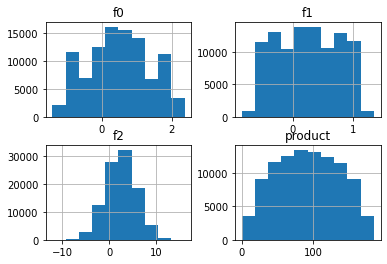

In [9]:
# Посмотрим как распределены данные в датафреймах
print(colored('region_1', attrs=['bold']))
df_1.hist();

region_2


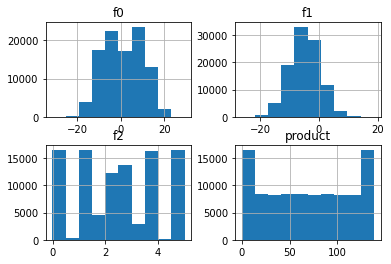

In [10]:
print(colored('region_2', attrs=['bold']))
df_2.hist();

region_3


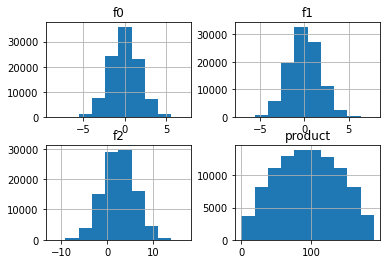

In [11]:
print(colored('region_3', attrs=['bold']))
df_3.hist();

In [12]:
# Удалим лишний признак из всех датафреймов, а именно столбец с id скважины
for name,i in group_df.items():
    i = i.drop(columns=['id'], axis=1, inplace=True)  

In [13]:
# Проверим, что признак удалился во всех датафреймах
for name,i in group_df.items():
    display(name, i.head())
    print('------------------------')

'region_1'

,f0,f1,f2,product
0,0.71,-0.50,1.22,105.28
1,1.33,-0.34,4.37,73.04
2,1.02,0.15,1.42,85.27
3,-0.03,0.14,2.98,168.62
4,1.99,0.16,4.75,154.04


------------------------


'region_2'

,f0,f1,f2,product
0,-15.00,-8.28,-0.01,3.18
1,14.27,-3.48,1.00,26.95
2,6.26,-5.95,5.00,134.77
3,-13.08,-11.51,5.00,137.95
4,12.70,-8.15,5.00,134.77


------------------------


'region_3'

,f0,f1,f2,product
0,-1.15,0.96,-0.83,27.76
1,0.26,0.27,-2.53,56.07
2,0.19,0.29,-5.59,62.87
3,2.24,-0.55,0.93,114.57
4,-0.52,1.72,5.90,149.60


------------------------


region_1


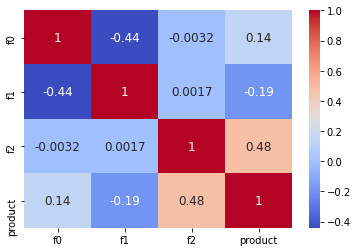

In [14]:
# Построим карту корреляции по каждому датафрейму
df_1_corr = df_1.corr(method="pearson")
sns.heatmap(df_1_corr, annot=True,annot_kws={"size":12},cmap="coolwarm");
print(colored('region_1', attrs=['bold']))

region_2


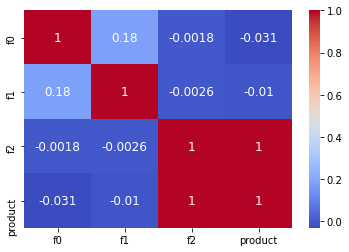

In [15]:
df_2_corr = df_2.corr(method="pearson")
sns.heatmap(df_2_corr, annot=True,annot_kws={"size":12},cmap="coolwarm");
print(colored('region_2', attrs=['bold']))

region_3


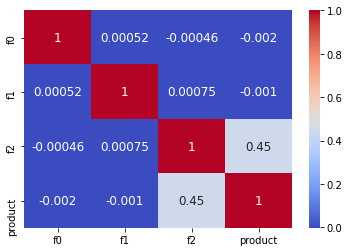

In [16]:
df_3_corr = df_3.corr(method="pearson")
sns.heatmap(df_3_corr, annot=True,annot_kws={"size":12},cmap="coolwarm");
print(colored('region_3', attrs=['bold']))

### Вывод: 
- В исходных данных содержится информация о трех регионах по 100 000 месторождений в каждом.
- Данные не содержат пропусков
- Обнаружено и удалено несколько дубликатов скважин с одинаковым ID.
- Признаки **f0, f1** вне зависимости от региона имеют характер распределения близкий к нормальному. Признак **f2** в первом и третьем регионе имеет распределние, близкое к нормальному, а во втором регионе распределние не соответствует нормальному.
- Пизнак **f2** имеет наиболее высокую корреляцию с объемом запасов в скважине, особенно во втором регионе. Это говорит о том, что при обучении модели этот признак будет самым значимым
- Признаки **f0, f1** имеют больше выбросов значений во втором регионе, в то время как признак **f2** наоборот, во втором регионе имеет самый маленький разброс значений.
- Объем запасов в скважинах в первом и третьем регионе имеет нормальное распределние, во втором регионе - запас в скважинах в основной массе находится на одном уровне. Средние значения запаса во втором регионе ниже, чем в двух других.
- Для дальнейшего построения модели мы удалили лишний признак с ID скважины.
- Признаки **f1, f2 и f3** не имеют большого разброса значений, поэтому масштабировать их не будем

## Обучение и проверка модели

In [17]:
# Создадим функцию для обучения модели и расчета показателей RMSE и среднего запаса сырья

def model(data):
    
    features = data.drop(['product'], axis=1) # Выделяем признаки
    target = data['product'] # Определяем целевой признак
    
    # Разбиваем на обучающую и валидационную выборки в соотношении 3:1
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    
    # Обучим модель линейной регрессии
    model = LinearRegression().fit(features_train, target_train)
    
    # Сделаем предсказания и преобразуем в Series
    predictions_valid = model.predict(features_valid)
    predictions_valid = pd.Series(predictions_valid)
    
    # Сбросим индексы у target
    target_valid = target_valid.reset_index(drop=True)
    
    # Расчитаем RMSE модели
    rmse = mean_squared_error(target_valid, predictions_valid) ** 0.5
    
    # Расчитаем средний предсказанный запас сырья
    pred_target_mean = predictions_valid.sum()/len(predictions_valid)
    
    return target_valid, predictions_valid, rmse, pred_target_mean

In [18]:
# Сохраним показатели, которые нам понадобятся в расчетах
target_valid_1, predictions_valid_1, rmse_1, pred_target_mean_1 = model(df_1)
target_valid_2, predictions_valid_2, rmse_2, pred_target_mean_2 = model(df_2)
target_valid_3, predictions_valid_3, rmse_3, pred_target_mean_3 = model(df_3)

In [19]:
# Выведем на экран средний предсказанный запас сырья и RMSE для регионов
print('Регион_1.', 'RMSE:', rmse_1.round(2), 'Средний предсказанный запас сырья:', pred_target_mean_1.round(2))
print('Регион_2.', 'RMSE:', rmse_2.round(2), 'Средний предсказанный запас сырья:', pred_target_mean_2.round(2))
print('Регион_3.', 'RMSE:', rmse_3.round(2), 'Средний предсказанный запас сырья:', pred_target_mean_3.round(2))

Регион_1. RMSE: 37.59 Средний предсказанный запас сырья: 92.61
Регион_2. RMSE: 0.89 Средний предсказанный запас сырья: 69.0
Регион_3. RMSE: 40.27 Средний предсказанный запас сырья: 94.95


### Вывод:
- Самый низкий показатель RMSE получился у модели второго региона. Очевидно, это  связано с сильной корреляцией одного из признаков с целевым. У первой и третьей модели RMSE значительно выше, так как и корреляция признака **f2** в них тоже гораздо ниже. Поскольку данные у нас синтетические, разобраться в причинах такой связи нет возможности.
- Самый низкий предсказанный запас сырья у второй модели, а у первой и третьей - выше, что соответствует средним данным по регионам.
- Также на данном этапе мы подготовили и сохранили часть данных для дальнейших расчетов.

## Подготовка к расчёту прибыли

In [20]:
# Сохраняем ключевые значения в отдельных переменных
TOTAL_OIL_WELL = 500 # количество скважин для исследования
OIL_WELL = 200 # количество скважин для разработки
BUDGET = 10_000_000_000 # бюджет на разработку
INCOM = 450000 # доход на 1 тыс.баррелей

In [21]:
# Рассчитаем достаточный запас сырья для безубыточной разработки скважины
sufficient_supply = BUDGET / OIL_WELL / INCOM
print('Достаточный запас сырья для безубыточной разработки скважины:',
      sufficient_supply, 'тыс.бар' )

Достаточный запас сырья для безубыточной разработки скважины: 111.11111111111111 тыс.бар


In [22]:
# Сравним средний запас сырья по регионам с достаточным
for name, i in group_df.items():
    res = i['product'].mean() - sufficient_supply
    if res < 0:
        print('Средний запас сырья в', name, 'меньше достаточного на', res)
    else:
        print('Средний запас сырья в', name, 'больше достаточного на', res)
            

Средний запас сырья в region_1 меньше достаточного на -18.61367994135695
Средний запас сырья в region_2 меньше достаточного на -42.28770248755704
Средний запас сырья в region_3 меньше достаточного на -16.113680269386833


### Вывод:
На данном этапе сделано следующее:
- Ключевым значениям присвоены отдельные переменные
- Рассчитан достаточный запас сырья на скважину для безубыточной работы. Его значение равно 111.11 тыс.баррелей
- Проверены и сравнены средние запасы сырья по каждому региону с достаточным запасом для безубыточной работы. В результате, все три региона имеют средний показатель запаса ниже достаточного уровня безубыточности


## Расчёт прибыли и рисков 

In [23]:
# Создаем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count] 
    return INCOM * selected.sum() - BUDGET

In [24]:
# Посчитаем прибыль и риски для каждого региона
def result(target_valid, predictions_valid):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target_valid.sample(n=TOTAL_OIL_WELL, replace=True, random_state=state)
        probs_subsample = predictions_valid[target_subsample.index] 
        res = revenue(target_subsample, probs_subsample, OIL_WELL)
        values.append(res/1000000)

    values = pd.Series(values)
    # Нижняя граница доверительного интервала
    lower = values.quantile(0.025) 
    # Верхняя граница доверительного интервала
    upper = values.quantile(0.975) 
    # Средняя прибыль
    mean = values.mean() 
    # Риск убытков
    risk = (values < 0).sum().sum() / 10 
            
    print('Средняя прибыль:', mean.round(2), 'млн.руб')
    print('95-й доверительный интервал:', '(', lower, ',', upper, ')')
    print('Риск убытков:', risk, '%')

In [25]:
print('-Регион 1-')
result(target_valid_1, predictions_valid_1)
print()
print('-Регион 2-')
result(target_valid_2, predictions_valid_2)
print()
print('-Регион 3-')
result(target_valid_3, predictions_valid_3)

-Регион 1-
Средняя прибыль: 425.49 млн.руб
95-й доверительный интервал: ( -88.63790506060987 , 966.9568525786822 )
Риск убытков: 5.3 %

-Регион 2-
Средняя прибыль: 514.55 млн.руб
95-й доверительный интервал: ( 66.04779794967651 , 934.3496937404443 )
Риск убытков: 0.7 %

-Регион 3-
Средняя прибыль: 343.23 млн.руб
95-й доверительный интервал: ( -203.2291641869327 , 912.187392641192 )
Риск убытков: 10.3 %


### Вывод:
В результате расчетов, получены следующие данные:
- Наибольшая величина средней прибыли во втором регионе, в нем же самый низкий процент риска убытков.
- Самый рискованный - третий регион, помимо этого у него самое низкое значение средней прибыли
- Самый узкий 95% доверительный интервал во втором регионе.

## Общий вывод:
1. В ходе изучения и подготовки данных, предоставленных для проекта, было обнаружено следующее:
 - Данные не содержали пропуски
 - В каждом датасете было несколько дубликатов по номеру `id` скважины. Для получения более чистого результата они были удалены.
 - Признаки `f0`, `f1`и `f2`не имели большого разброса значений, поэтому в дальнейшем не были масштабированы
 - Выявлена корреляция признака `f2` с целевым признаком, особенно сильная во втором регионе. У двух других признаков `f0` и `f1` корреляции с целевым признаком не обнаружено
2. При обучении и проверки модели получены следующие результаты:
 - Самый низкий показатель `RMSE - 0,89` получился у модели второго региона. Очевидно, это  связано с сильной корреляцией одного из признаков с целевым. У первой и третьей модели RMSE значительно выше. 
 - Самый низкий средний предсказанный запас сырья -`69.0 тыс.бар.`, оказался у второй модели, а у третьей - самый высокий - `94,95 тыс.бар`. Во всех регионах средний предсказанный запас сырья оказался ниже достаточного запаса для безубыточной работы, который по расчетным данным составил `111,11 тыс.бар`.  
3. Результаты расчета прибыли и возможных рисков следующие:
 - Наибольшая величина средней прибыли `514.55 млн.руб` во втором регионе, в нем же самый низкий процент риска убытков - `0.7 %`.
 - Самый рискованный - третий регион, помимо этого у него самое низкое значение средней прибыли
 - Самый узкий 95% доверительный интервал во втором регионе. 

**По итогам проекта, к дальнейшей разработке скважин предлагается `второй регион`, поскольку он имеет самый высокий показатель средней прибыли и самый низкий процент риска убытков.**